# Microbiome machine learning analysis

## Setup

### Import the calour module

In [1]:
import calour as ca

/Users/zech/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib notebook

## Loading the data

We will use the data from Qitta study 103 (https://qiita.ucsd.edu/study/description/103#)

In [3]:
dat=ca.read_amplicon('data/88-soil.biom',
                     'data/88-soil.sample.txt',
                     normalize=100,min_reads=10)

In [4]:
print(dat)

AmpliconExperiment ("88-soil.biom") with 88 samples, 7396 features


## Process the data

### Get rid of the features (bacteria) with small amount of reads
We throw away all features with total reads (over all samples) < 10 (after each sample was normalized to 10k reads/sample). So a bacteria present (with 1 read) in 10 samples will be kept, as well as a bacteria present in only one sample, with 10 reads in this sample.
Note alternatively we could filter based on mean reads/sample or fraction of samples where the feature is present. Each method filters away slightly different bacteria. See **filtering** notebook for details on the filtering functions.

In [5]:
dat=dat.filter_abundance(1)
dat

AmpliconExperiment ("88-soil.biom") with 88 samples, 1756 features

### Use soil microbiome to predict its pH

In [6]:
from sklearn.ensemble import RandomForestRegressor
from calour.training import plot_scatter

Let's look at the distribution of pH for all the samples:

<IPython.core.display.Javascript object>


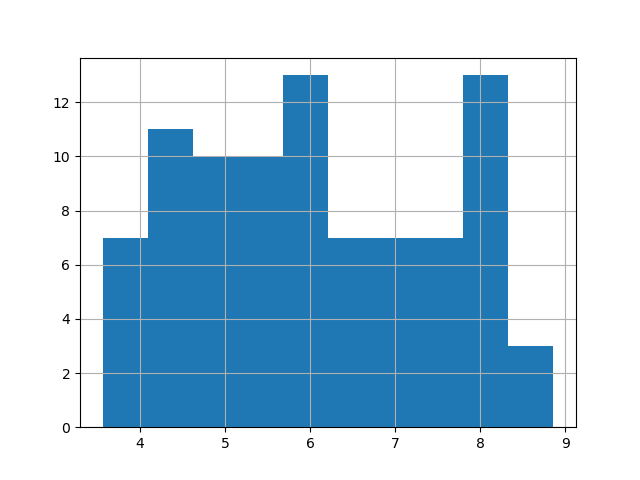

In [7]:
dat.sample_metadata['ph'].hist()

<IPython.core.display.Javascript object>


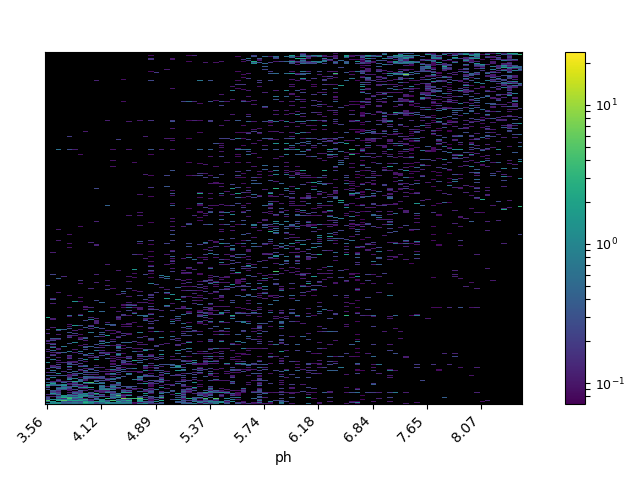

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [8]:
dat.sort_samples('ph').sort_centroid(n=0.001).plot(sample_field='ph', gui='jupyter')

We can then run regression analysis:

In [9]:
it = dat.regress('ph', RandomForestRegressor(random_state=0), cv=5, params=[{'n_estimators':3}, {'n_estimators': 500}])

This function returns a generator, which yields the prediction result for each parameter set specified in `params`. Here we would like to see how the number of trees (named `n_estimators`) in the model impact its performance. The result with `n_estimators = 10` is:

In [10]:
res1 = next(it)

In [11]:
res1.head()

,CV,SAMPLE,Y_PRED,Y_TRUE
0,0,103.CA2,7.656667,8.02
1,0,103.CO3,7.143333,6.02
2,0,103.SR3,7.350000,6.95
3,0,103.IE2,5.726667,5.52
4,0,103.BP1,6.476667,7.53


We can plot out the result as following. Each dot is a sample with observed and predicted pH, colored by the fold of cross validation the sample is from. The diagonal line indicates perfect predition. The correlation coefficient and its p-value between the prediction and observation are also annotated around the top of the plot.

<IPython.core.display.Javascript object>


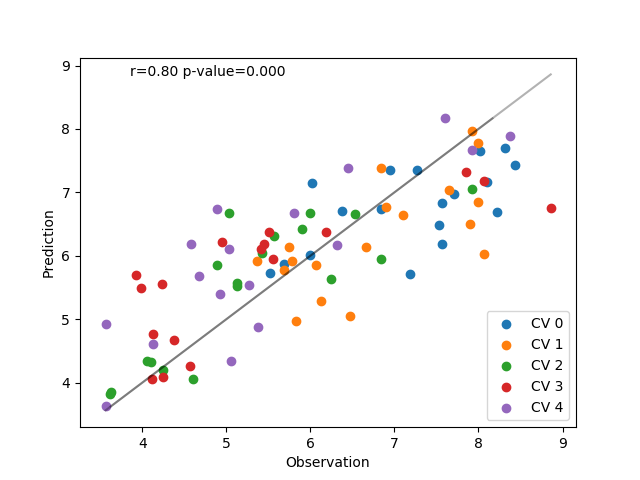

In [13]:
plot_scatter(res1, cv=True)

Let's look at the result for `n_estimators = 500`:

In [14]:
res2 = next(it)

In [15]:
res2.head()

,CV,SAMPLE,Y_PRED,Y_TRUE
0,0,103.CA2,7.02582,8.02
1,0,103.CO3,6.36924,6.02
2,0,103.SR3,7.51494,6.95
3,0,103.IE2,5.55394,5.52
4,0,103.BP1,7.03446,7.53


<IPython.core.display.Javascript object>


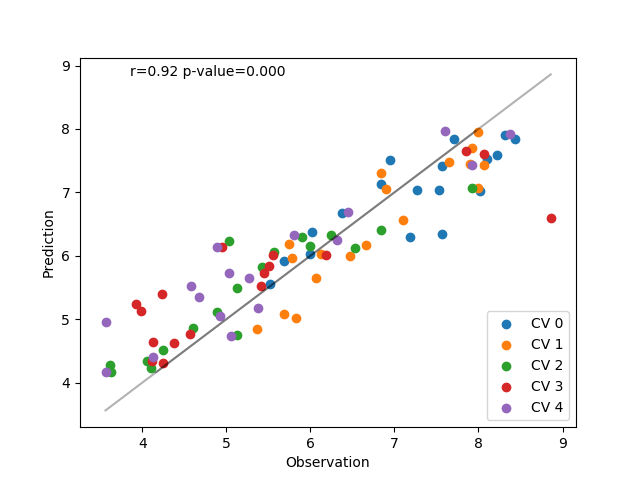

In [16]:
plot_scatter(res2, cv=True)

From the plot, you can see, with more trees in the Random Forest model, the prediction is much better with a higher correlation coefficient.